In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyrootutils

base_path = pyrootutils.setup_root(
    search_from=".",
    indicator=[".gitignore"],
    project_root_env_var=True,  # set the PROJECT_ROOT environment variable to root directory
    dotenv=True,  # load environment variables from .env if exists in root directory
    pythonpath=True,  # add root directory to the PYTHONPATH (helps with imports)
    cwd=True,  # change current working directory to the root directory (helps with filepaths)
)
import sys
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import json
import wandb
import matplotlib
import matplotlib as mpl
from itertools import combinations
import os
import shutil
from sklearn.metrics import roc_auc_score

from src.utils.metrics import *
from src.data.utils import *
from src.utils.eval import *
from src.utils.wandb import *

from src.data.utils import *
from src.utils.data_paths_anca import *

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)

## Load data

In [3]:
sc_paths, st_paths, simulation_paths, experiment_paths = get_paths_for_processing(
    base_path,
    st_data_files,
    sc_data_files,
    celltype_cols,
    extra_settings_sim,
    extra_settings_prep,
    data_dir="data",
    use_old_experiment_paths=True,
    experiment_dirs=experiment_dirs,
)
dataset_names_orig = dataset_names
dataset_map = get_dataset_map(experiment_paths, dataset_names)
dataset_path_map = get_dataset_path_map(st_paths, dataset_names)

No experiment_dirs provided, using default


In [4]:
st_paths

['/data/DISSECT/data/spatial/anca_visium/test_sample.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V1_A.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V1_B.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V1_C.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V1_D.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V2_A.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V2_B.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V2_C.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V2_D.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V3_A.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V3_B.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V3_C.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V3_D.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V4_A.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V4_B.h5ad',
 '/data/DISSECT/data/spatial/anca_visium/sample_V4_C.h5ad',
 '/data/DISSECT/data/spatial/anca_visium

In [40]:
idx = -2
st_data = sc.read_h5ad(st_paths[idx])
# sc_data = sc.read_h5ad(sc_paths[idx])

if len(st_data.uns["spatial"].keys()) > 1:
    
    new_uns_dict = {"ANCA-visium": st_data.uns["spatial"]}
    st_data.uns["spatial"] = new_uns_dict

sc.pp.normalize_total(st_data, target_sum=1e4)
sc.pp.log1p(st_data)

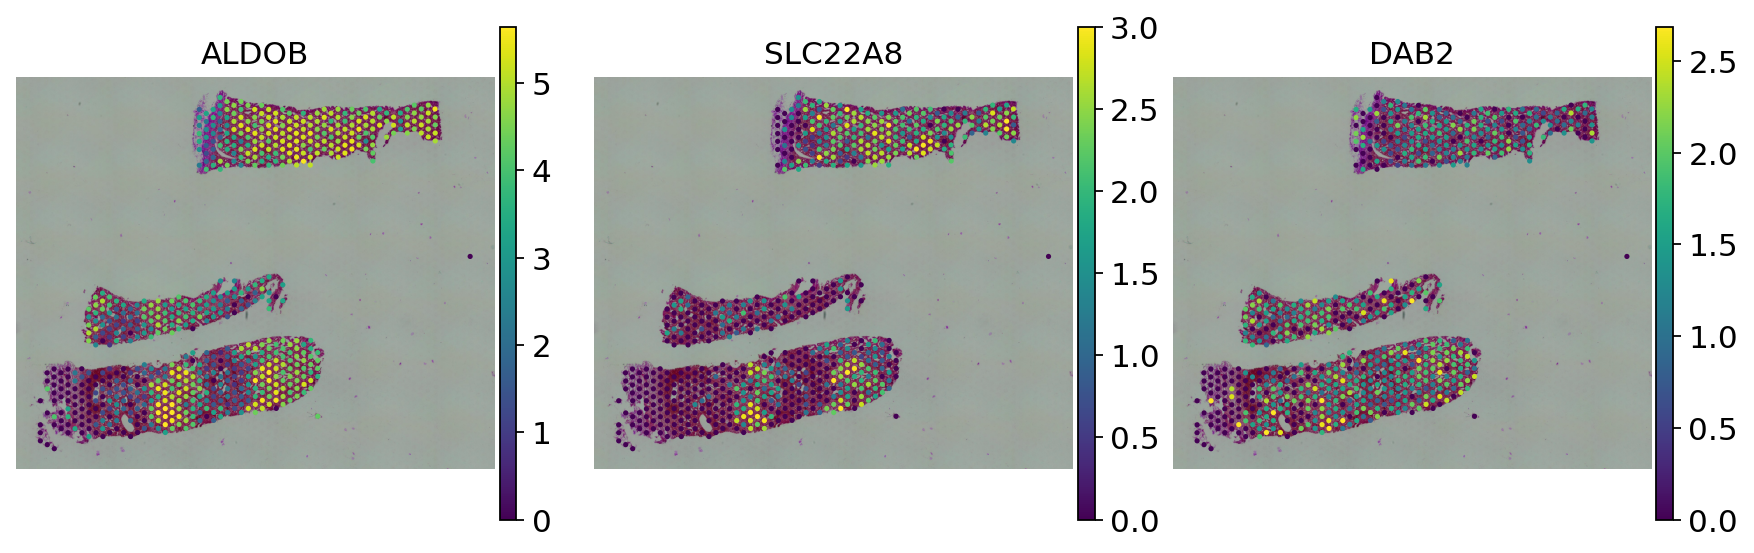

In [48]:
gene_list = ["PDGFRA", "FBLN1", "VIM", "FAP", "S100A4", "PDGFRB"] # fibroblast markers
gene_list = ["ALDOB", "SLC22A8", "DAB2"] # proximal tubule markers
fig = sc.pl.spatial(
    st_data,
    color=gene_list,
    show=False,
    save=False,
    vmin=0.0,
    vmax="p99",
    wspace=0.1,
    ncols=3,
    # library_id="images",
)


In [ ]:
st_data.uns["spatial"]

## Load results

In [19]:
runs = get_runs_for_tags_and_filters(baseline_tag="anca_latest")
results = {}
sample_path_map = {}
run_dataset_names = []
for run in runs:
    run_dataset_name = extract_dataset_name(run.config["data/reference_dir"], dataset_map)
    st_path = dataset_path_map[run_dataset_name]
    sample_name = "_".join(st_path.split(".")[0].split("/")[-1].split("_")[1::])
    results[sample_name] = get_result_for_run(run)
    sample_path_map[sample_name] = st_path


Loaded 25 runs


In [15]:
sample_name

'V6_C'

In [24]:
results[0].shape

(632, 21)

In [20]:
path = "./experiments/experiment_kidney/test_sample"
test_result_dissect = load_dissect_results(path)[1]
# test_result_dissect

## Qualitative analysis

V6_C


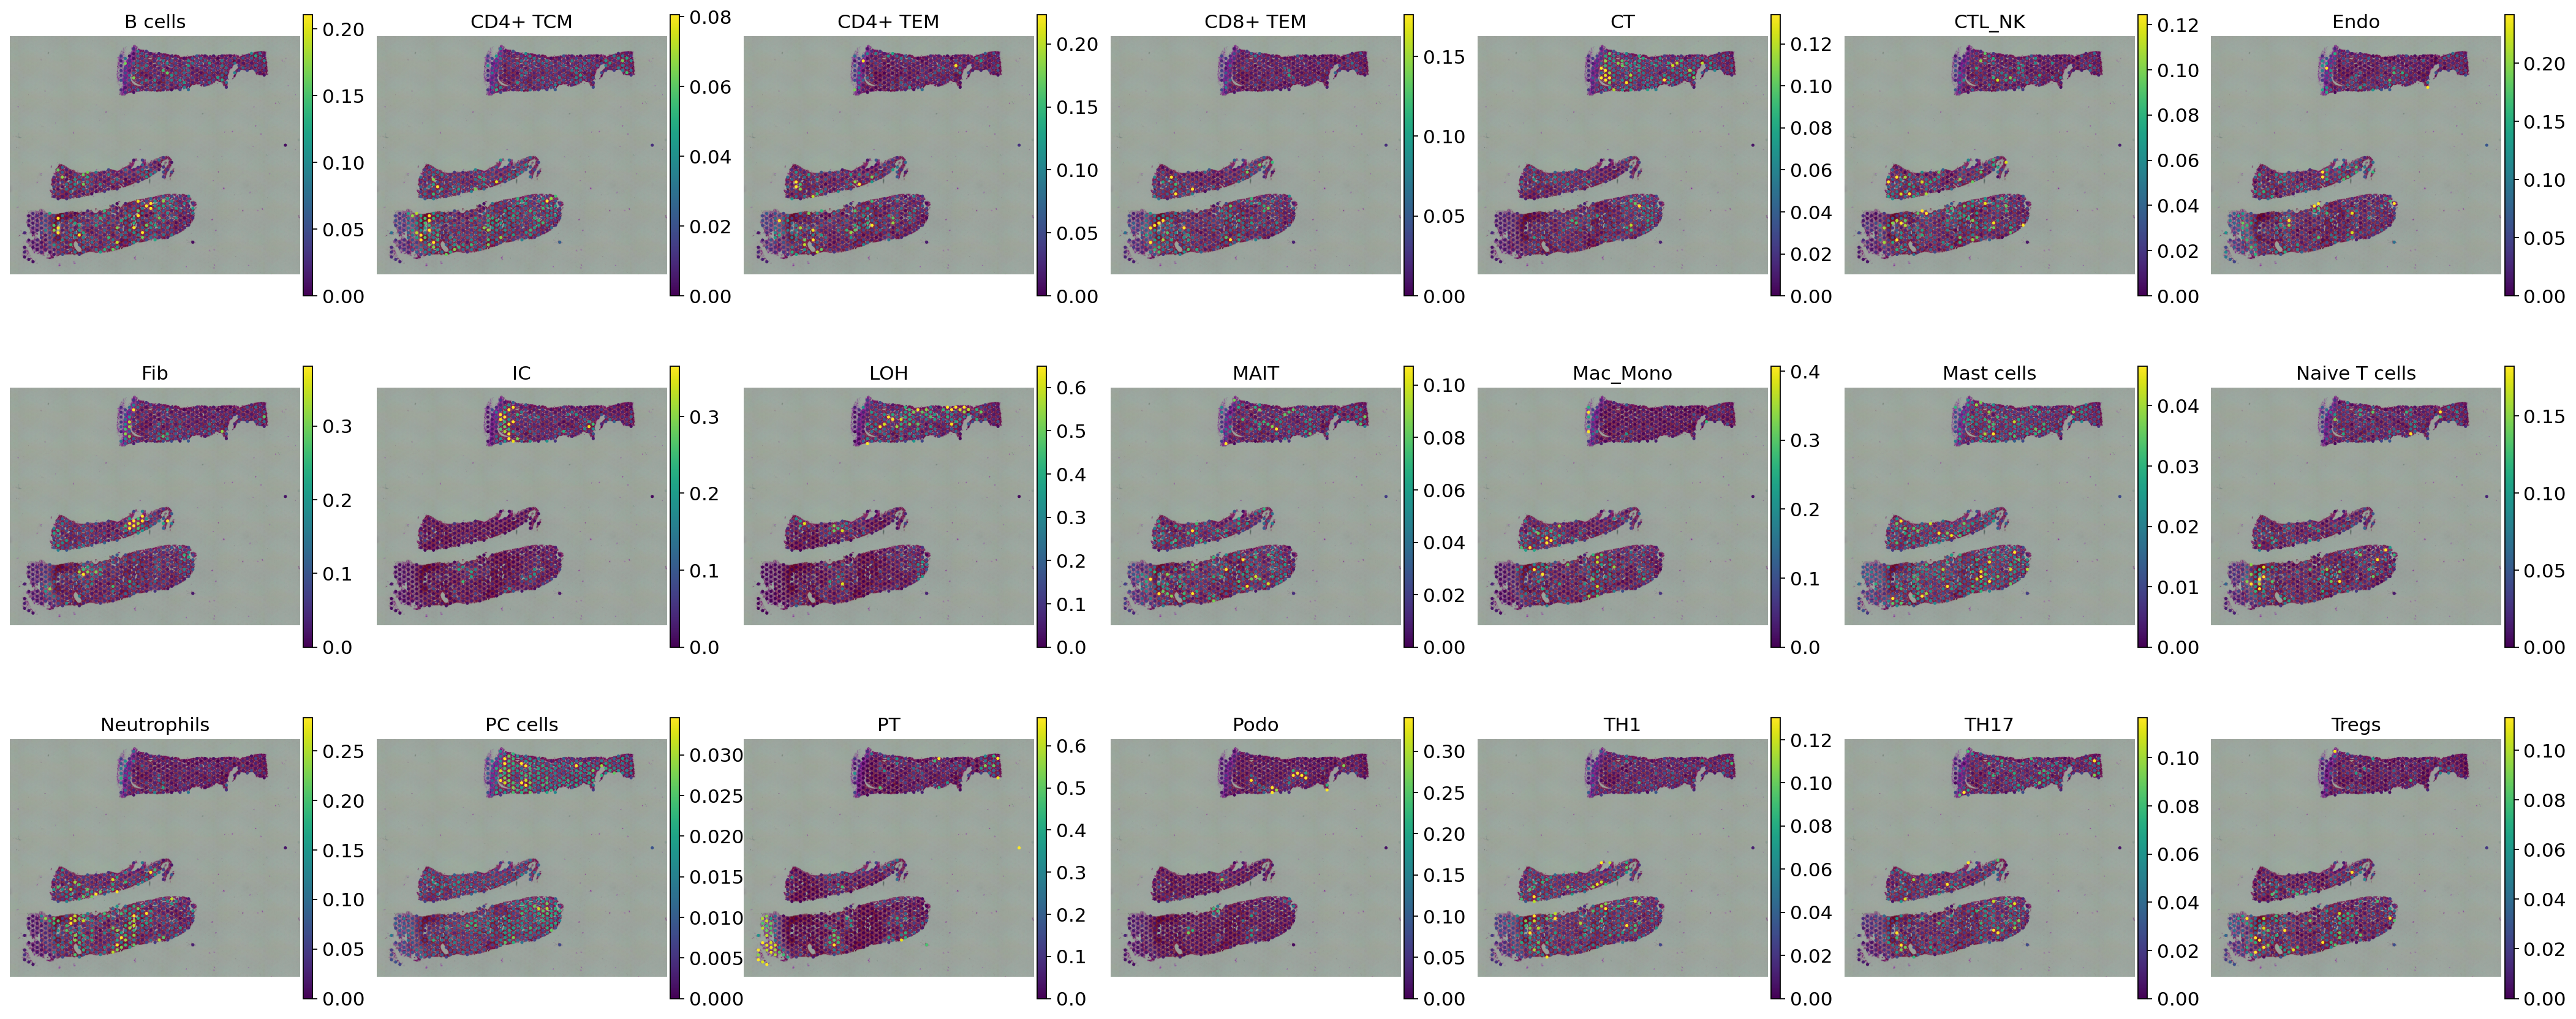

In [39]:
for sample_name, result in list(results.items())[1:2]:
    print(sample_name)
    st_path = sample_path_map[sample_name]
    st_data = sc.read_h5ad(st_path)
    assert (result.index == st_data.obs.index).all()
    if len(st_data.uns["spatial"].keys()) > 1:
        new_uns_dict = {"ANCA-visium": st_data.uns["spatial"]}
        st_data.uns["spatial"] = new_uns_dict
    
    st_data.obs = pd.concat([st_data.obs, result], axis=1)
    fig = sc.pl.spatial(
        st_data,
        color=list(result.columns)[0::],
        # color=["Fib", "TH1", "TH17"],
        show=False,
        save=False,
        vmin=0.0,
        vmax="p99",
        # vmax=0.06,
        wspace=0.15,
        ncols=7,
        # library_id="images",
        # cmap="seismic",
    )
    # plt.savefig(f"./figures/anca_test_sample_{run_name}.png", dpi=80, bbox_inches="tight")
    plt.show()


In [17]:
st_data.obs.index

Index(['AAACCTCATGAAGTTG-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACGAGACGGTTGAT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACTGCTGGCTCCAA-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAAGACTGGGCGCTTT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAAGGGCAGCTTGAAT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAAGTCGACCCTCAGT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAATACCTATAAGCAT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAATCGTGTACCACAA-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAATGCTCGTTACGTT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAATGTATCTTATCCC-1-1-0-0-0-0-0-0-0-0-0-0-0',
       ...
       'TTGCGTAGTTTGAGGA-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGCTCCCATACCGGA-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGCTGCACCTATCCA-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGGCCATCTTGCGCT-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGGCCTAGAATTTCG-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGGGACACTGCCCGC-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGGGCGGCGGTTGCC-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGTAAGGCCAGTTGG-1-1-0-0-0-0-0-0-0-0-0-0-0',
       'TTGTTCTAGATACGCT-1-1-0-0-0-

In [6]:
assert (test_result_gnn.index == st_data.obs.index).all()
st_data.obs = pd.concat([st_data.obs, test_result_gnn], axis=1)
fig = sc.pl.spatial(
    st_data, color=list(test_result_gnn.columns)[0::], show=False, save=False, vmin=0.0, vmax="p99", wspace=0.1, ncols=7)
# plt.savefig(f"./figures/anca_test_sample_{run_name}.png", dpi=80, bbox_inches="tight")
plt.show()

NameError: name 'test_result_gnn' is not defined

/root/miniconda3/envs/dissect-spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


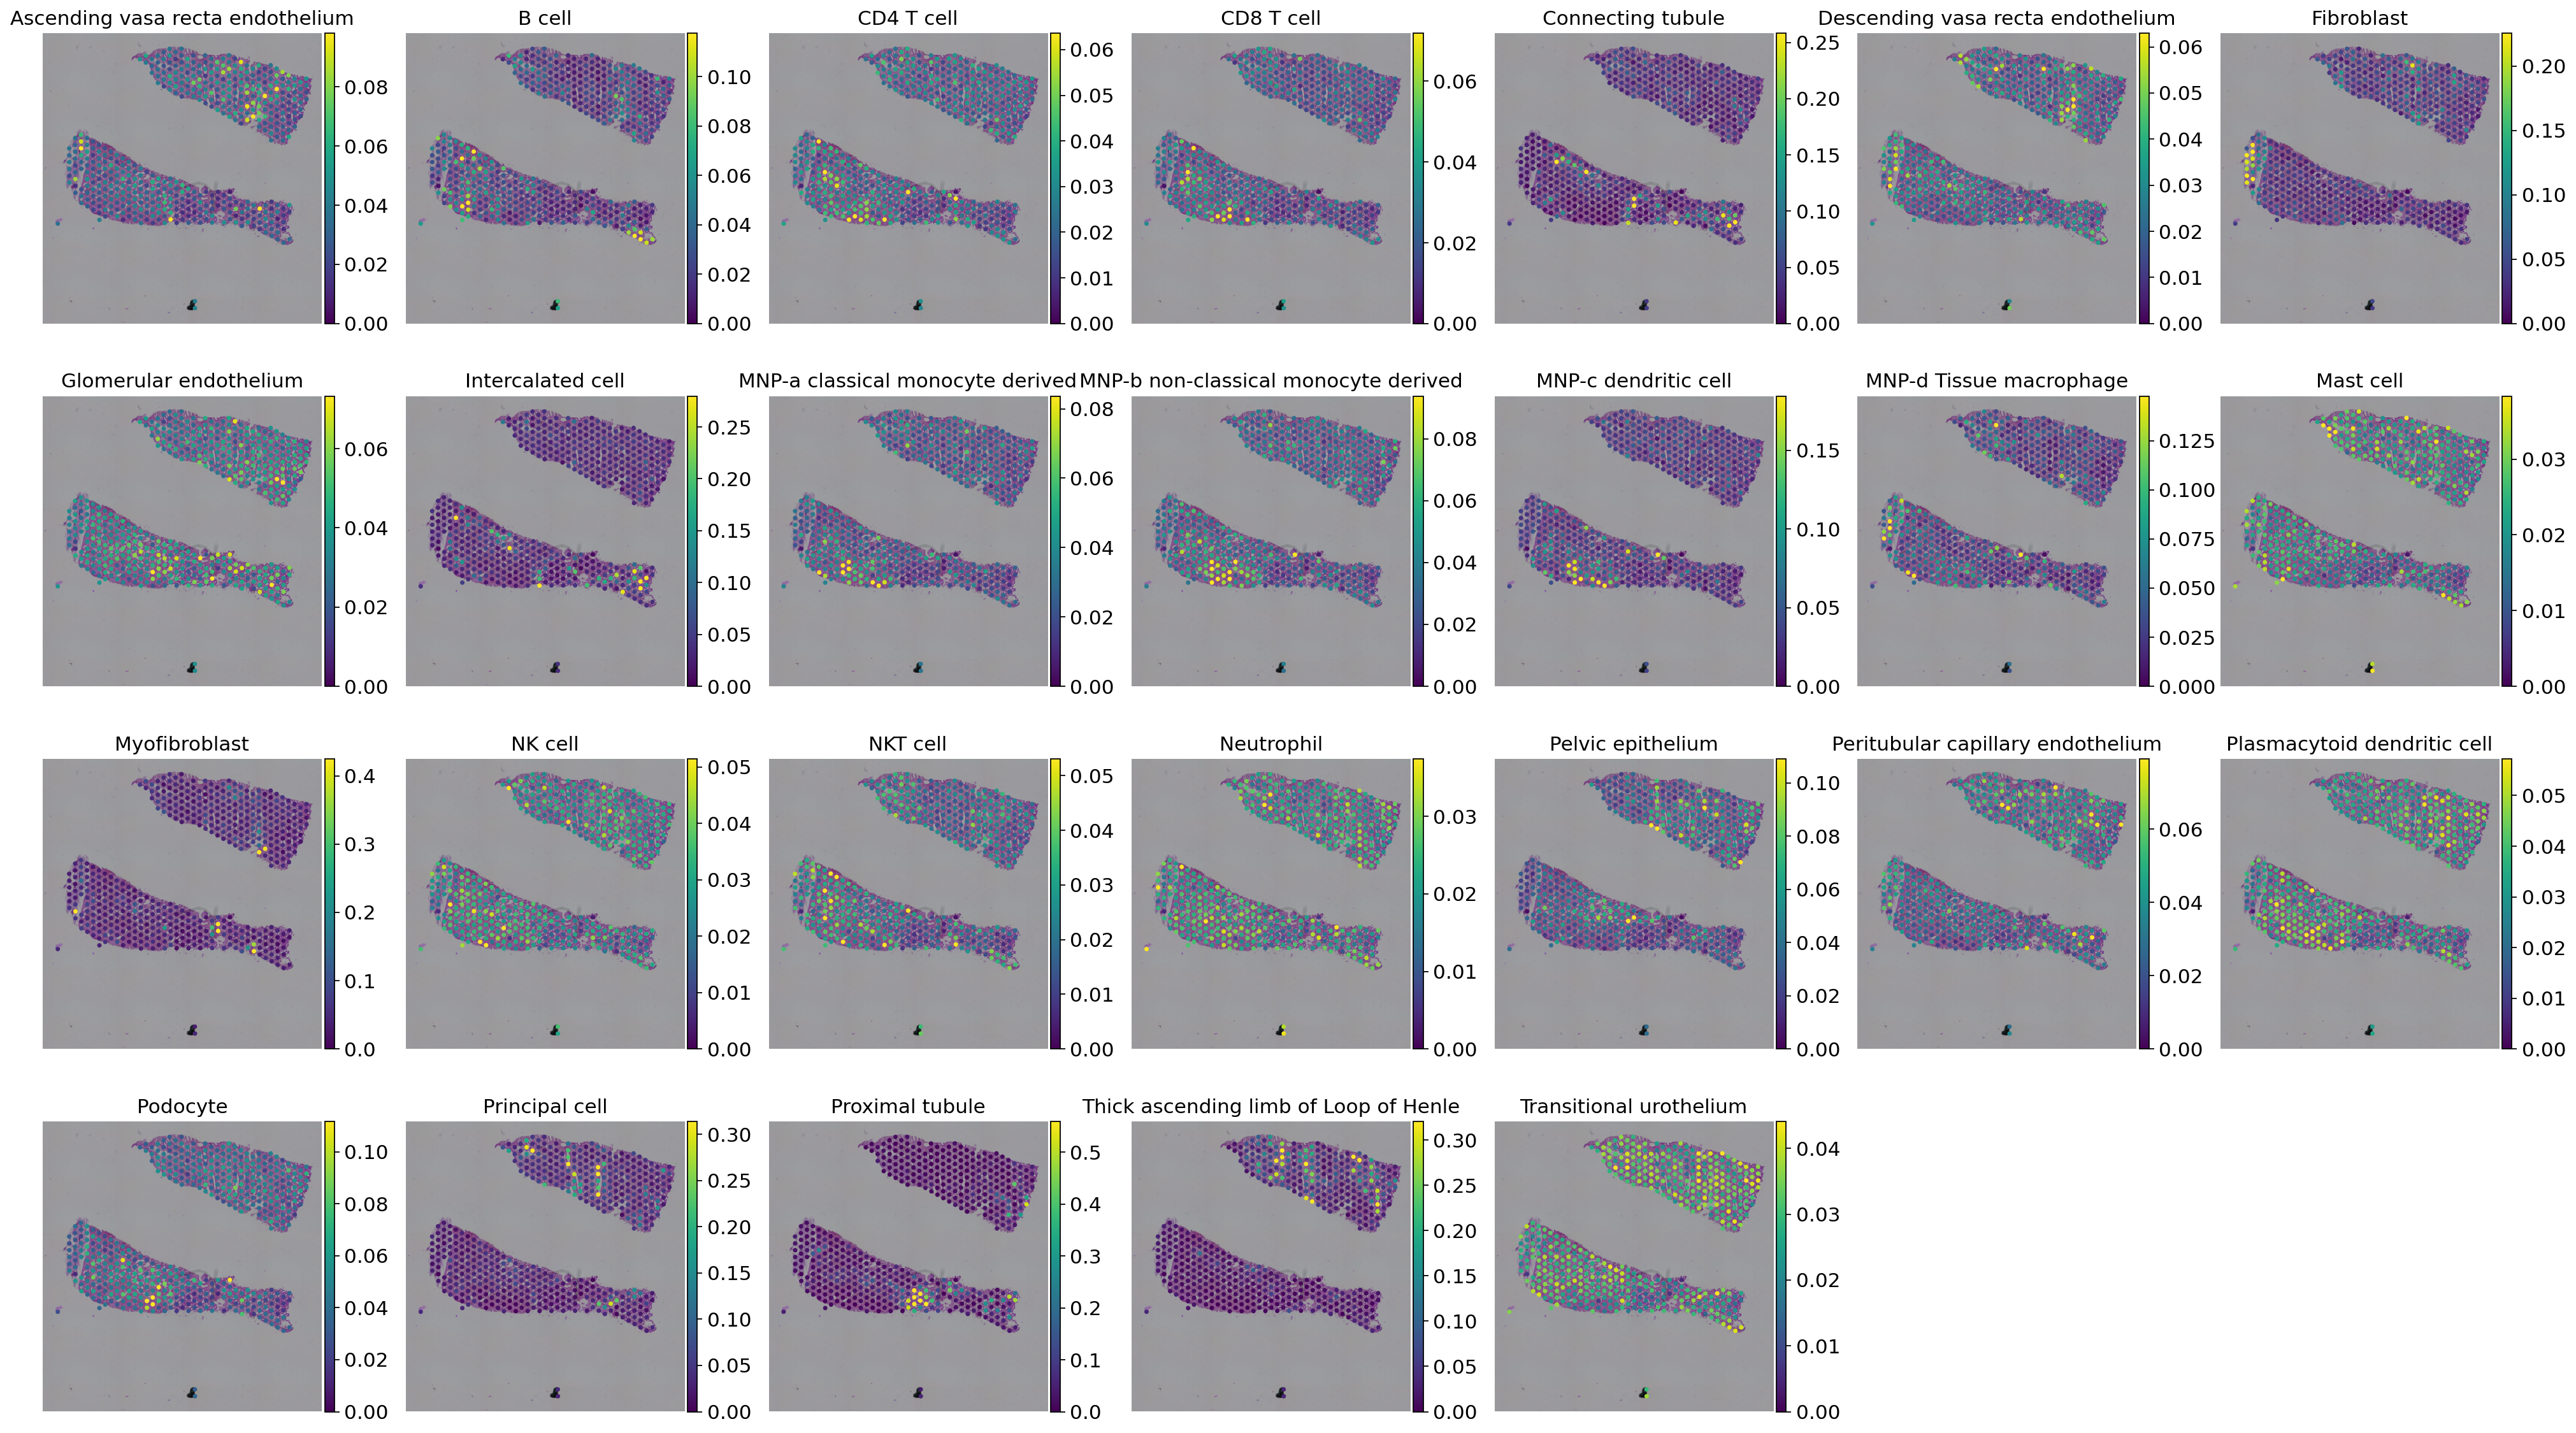

In [17]:
st_data = sc.read_h5ad(st_path)
assert (test_result_dissect.index == st_data.obs.index).all()
st_data.obs = pd.concat([st_data.obs, test_result_dissect], axis=1)
fig = sc.pl.spatial(
    st_data, color=list(test_result_dissect.columns)[0::], show=False, save=False, vmin=0.0, vmax="p99", wspace=0.1, ncols=7)
plt.savefig(f"./figures/anca_test_sample_dissect.png", dpi=80, bbox_inches="tight")
plt.show()

### Closer look at CD4+ T cells

/root/miniconda3/envs/dissect-spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


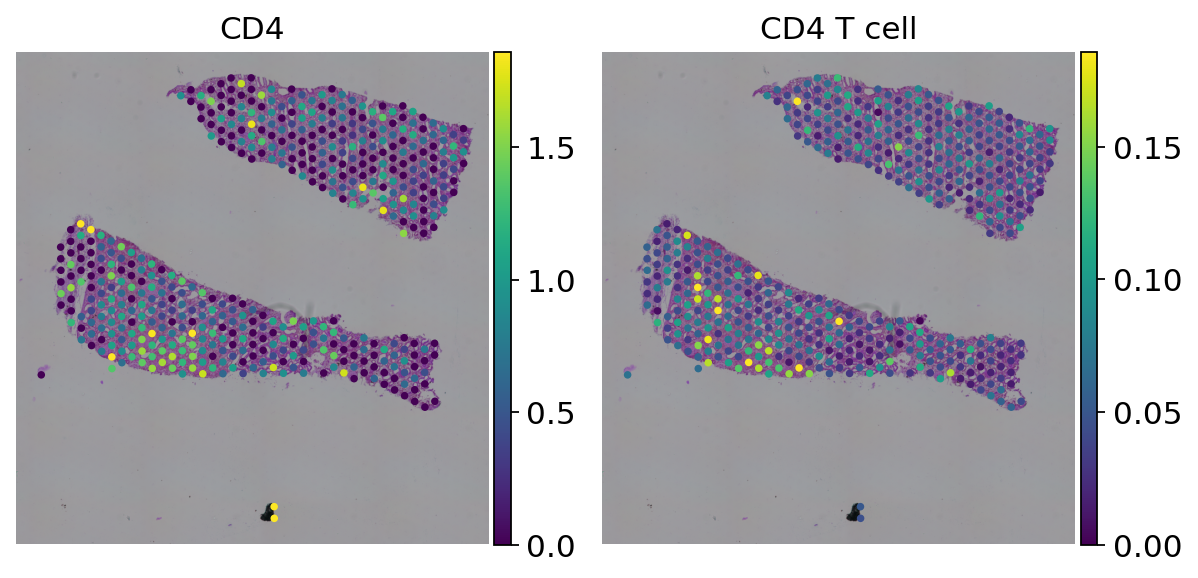

In [19]:
st_data = sc.read_h5ad(st_path)
assert (test_result_gnn.index == st_data.obs.index).all()
st_data.obs = pd.concat([st_data.obs, test_result_gnn], axis=1)
sc.pp.normalize_total(st_data, target_sum=1e4)
sc.pp.log1p(st_data)
fig = sc.pl.spatial(
    st_data, color=["CD4", "CD4 T cell"], show=False, save=False, vmin=0.0, vmax="p99", wspace=0.1, ncols=2)
plt.savefig(f"./figures/anca_test_sample_cd4_{run_name}.png", dpi=200, bbox_inches="tight")
plt.show()